# Tâche 9

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from scipy import integrate 
from scipy.optimize import minimize

In [13]:
with MPRester("MVjrPtjUJ4K2IdZ4zJmL2QqGBqEUCt6C") as m:
    prim_struct = m.get_structure_by_material_id("mp-22660")
    ph_dos = m.get_phonon_dos_by_material_id("mp-22660")

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Calcul des températures d'Einstein et de Debye

Einstein a supposé que chaque atome du cristal vibre autour de sa position d'équilibre à une même fréquence $\omega_{E}$. On a donc l'expression de la chaleur spécifique : $\frac{C_{v}}{3N_{at}R} = (\frac{\Theta_{E}}{T})^2\frac{e^{\frac{\Theta_E}{T}}}{(e^{\frac{\Theta_E}{T}} - 1)^2}$ avec $\Theta_E = \frac{ħ \omega_E}{k_B}$ la température d'Einstein.

Debye a effectué l'hypothèse que les fréquences propres ont la même dispersion linéaire : $\omega_{\sigma}(q) = vq$. On a donc l'expression de la chaleur spécifique : $\frac{C_v}{3N_{at}R} = 3(\frac{\Theta_D}{T})^3\int_{0}^{\frac{\Theta_D}{T}}{\frac{x^4e^x}{(e^x - 1)^2}}dx$ avec $\Theta_D = \frac{ħ \omega_D}{k_B}$ la température d'Einstein.

In [14]:
temperatures = np.arange(5,1000,5)
R = 8.314 # : Constante des gaz parfaits
N_at = len(prim_struct) # : Nombre d'atome
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))]) /(3*N_at*R)

In [15]:
# Modèle d'Einstein
def cv_Einstein(T, Te):
    return (Te/T)**2*np.exp(Te/T) / (np.exp(Te/T)-1)**2

def error_Einstein(Te):
    cv_E = cv_Einstein(temperatures, Te)  
    return np.sum((ph_cv - cv_E)**2)

Te_init = 200
Te_optimal = minimize(error_Einstein, Te_init).x[0]

print("La température d'Einstein qui minimise l'erreur au sens des moindres carrés est de", str(Te_optimal), "K")

La température d'Einstein qui minimise l'erreur au sens des moindres carrés est de 373.5080034537087 K


In [16]:
# Modèle de Debye
def integrande(x):
    return (x**4*np.exp(x)) / (np.exp(x)-1)**2

def cv_Debye(T, Td):
    return 3*(T/Td)**3 * integrate.quad(integrande,0,Td/T)[0]

def error_Debye(theta_D):
    return np.sum([(cv_Debye(temperatures[i], theta_D) - ph_cv[i])**2 for i in range(len(temperatures))])

Td_init = 200
Td_optimal = minimize(error_Debye, Td_init).x[0]

print("La température de Debye qui minimise l'erreur au sens des moindres carrés est de", str(Td_optimal), "K")

La température de Debye qui minimise l'erreur au sens des moindres carrés est de 507.21499127749274 K


## Représentation des courbes de chaleurs spécifiques

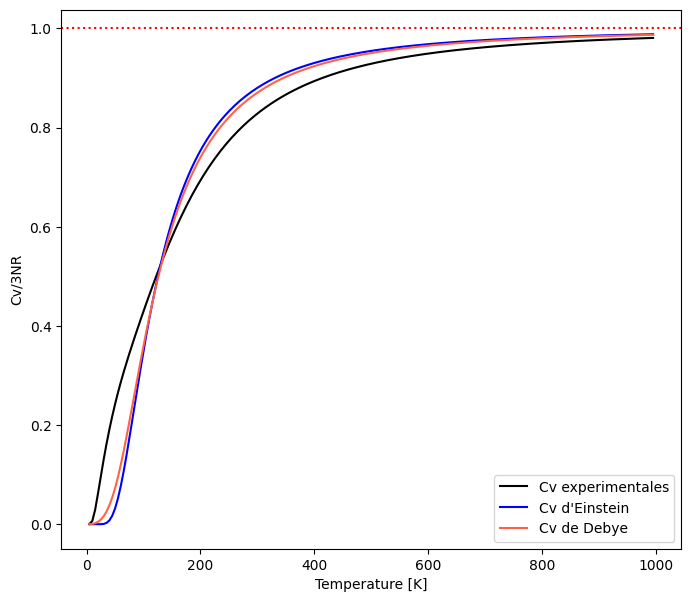

In [17]:
cv_E = cv_Einstein(temperatures, Te_optimal)
cv_D = np.array([cv_Debye(temp, Td_optimal) for temp in temperatures])

plt.figure(figsize=(8, 7))
plt.plot(temperatures, ph_cv, label="Cv experimentales", color='black')
plt.plot(temperatures, cv_E, label="Cv d'Einstein" , color='blue')
plt.plot(temperatures, cv_D, label="Cv de Debye", color='tomato')
plt.axhline(y=1, color='red', linestyle= 'dotted')
plt.xlabel('Temperature [K]')
plt.ylabel("Cv/3NR")
plt.legend()
plt.show()

#### On obtient donc que $\Theta_E = 373.5K$ et que $\Theta_D = 507.2K$. Sur le graphe, on peut observer que les 3 courbes convergent vers la loi de Dupont et Petit : $C_v \xrightarrow{} 3 N_{at}R$ (la ligne en pointillé rouge) et  on observe bien que le modèle de Debye est + proche des données expérimentales que le modèle d'Einstein.

## Représentation des densités d'états de phonons

In [18]:
frequencies = ph_dos.frequencies
densities = ph_dos.densities

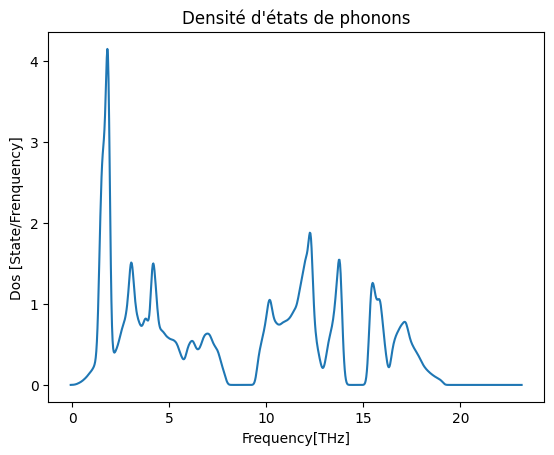

In [19]:
# Plot de la densité d'états des phonons 
plt.plot(frequencies, densities)
plt.xlabel('Frequency[THz]')
plt.ylabel('Dos [State/Frenquency]')
plt.title('Densité d\'états de phonons')
plt.show()

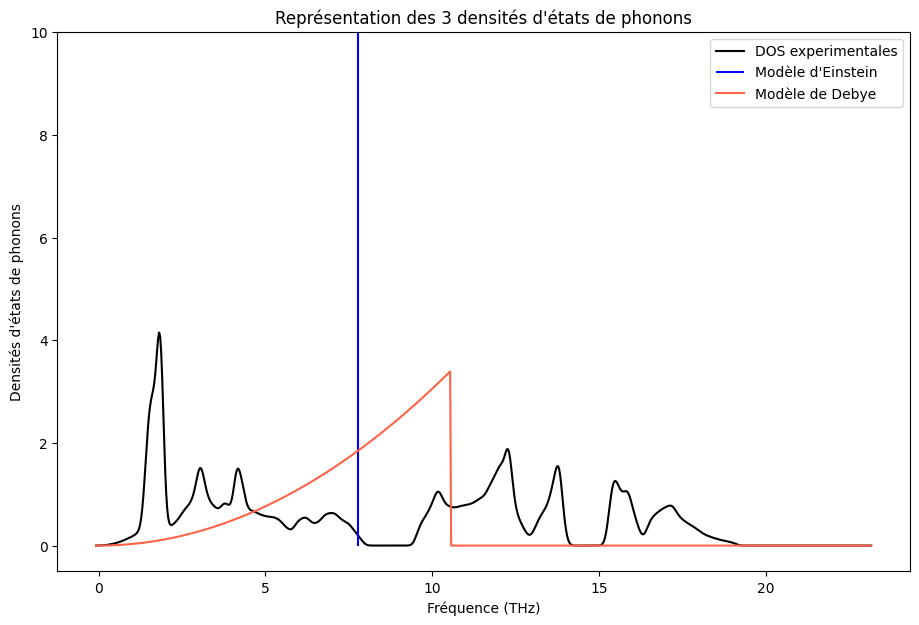

In [20]:
kB = 1.3806485e-23 # J/K : Constante de Boltzmann
hbar = 1.055e-34 # J.s  : Constante de Planck
THz = 1e-12

Theta_E = Te_optimal * kB * THz / hbar
Theta_D = Td_optimal * kB * THz / hbar  

dos_D = np.zeros(len(frequencies))
for i,f in enumerate(frequencies):
    T = 2*np.pi*f
    if T < Theta_D:
        dos_D[i] = (9*N_at*(T)**2/(Theta_D**3))

plt.figure(figsize=(11, 7))
plt.plot(frequencies, densities ,color = "black", label="DOS experimentales")
plt.vlines(Theta_E/(2*np.pi), 0, 3 * N_at ,color ="blue", label = "Modèle d'Einstein") 
plt.plot(frequencies, dos_D*(2*np.pi), color="tomato", label="Modèle de Debye")
plt.title("Représentation des 3 densités d'états de phonons")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence (THz)")
plt.ylim(-0.5, 10)
plt.legend()
plt.show()

#### Le modèle d'Einstein propose une fréquence unique pour tous les modes, c'est la raison pour laquelle ce modèle théorique ne reproduit pas correctement la densité d’états phononique obtenue par calcul. Le modèle de Debye est meilleur à basse fréquence mais ne tient pas compte des modes optiques présents à haute fréquence.

In [21]:
# Calcul des aires
dens_E = 3*N_at # Aire sous la courbe
A_einstein = dens_E
A_exp = 0
A_debye = 0
for i in range(len(frequencies)-1) : 
    A_exp += (densities[i])*(frequencies[i+1] - frequencies[i])
    A_debye += (dos_D[i]*2*np.pi)*(frequencies[i+1] - frequencies[i])
print("Aire sous la courbe des résultats expérimentaux : " + str(A_exp))
print("Aire sous la courbe de Debye : " + str(A_debye))
print("Aire sous la courbe d'Einstein : " + str(A_einstein))

Aire sous la courbe des résultats expérimentaux : 11.999991366470693
Aire sous la courbe de Debye : 11.969045957949652
Aire sous la courbe d'Einstein : 12


#### On observe bien que les 3 aires sous la courbes sont égales.